In [251]:
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer,porter
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import AffinityPropagation, DBSCAN
from sklearn import metrics

import string
import pandas
import numpy as np
import re

from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.dates as mpd
from itertools import cycle
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


In [397]:
# read data
def maxCase(x):
    result = [i for (i,v) in zip(range(-2,3),[y==max(x) for y in x]) if v]
    if(len(result) > 1):
        s = sum(result)
        if(s < -2):
            return -2
        elif(s > 2):
            return 2
        else:
            return s
    else:
        return result[0]
    
def worstCase(x):
    if x['vneg']>0:
        return -2
    elif x['neg']>0:
        return -1
    elif x['neutral']>0:
        return 0
    elif x['pos']>0:
        return 1
    else:
        return 2
    
def bestCase(x):
    if x['vpos']>0:
        return 2
    elif x['pos']>0:
        return 1
    elif x['neutral']>0:
        return 0
    elif x['neg']>0:
        return -1
    else:
        return -2
    
def twoClass(x):
    if x<0:
        return -1
    else:
        return 1

reviews = pandas.read_pickle('consumer_affairs_sallie_mae.data')
reviews['review'] = reviews['review'].apply(lambda x: re.sub(r'acct','account',x,flags=re.IGNORECASE))
reviews['review'] = reviews['review'].apply(lambda x: re.sub(r'thats','that\'s',x,flags=re.IGNORECASE))
reviews['review'] = reviews['review'].apply(lambda x: re.sub(r'interesrt','interest',x,flags=re.IGNORECASE))
reviews['review'] = reviews['review'].apply(lambda x: re.sub(r'don\'t','do not',x,flags=re.IGNORECASE))
reviews['review'] = reviews['review'].apply(lambda x: re.sub(r'wouldn\'t','would not',x,flags=re.IGNORECASE))
reviews['review'] = reviews['review'].apply(lambda x: re.sub(r'couldn\'t','could not',x,flags=re.IGNORECASE))
reviews['review'] = reviews['review'].apply(lambda x: re.sub(r'shouldn\'t','should not',x,flags=re.IGNORECASE))


sentiments = pandas.read_csv('review_sentiment_coreNLP.txt')
sentiments_R = pandas.read_csv('Score_of_reviews.csv')['scores']
reviews['sentiment'] = sentiments.apply(bestCase,axis=1).apply(twoClass)

In [464]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(",".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

def top_words(model,feature_names,n_top_words):
    topics = []
    terms = []
    for topic_idx, topic in enumerate(model.components_):
        topics.append(topic_idx)
        terms.append(','.join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    return pandas.DataFrame({'topic':topics,'terms':terms},columns=['topic','terms'])    

def noPunct(txt):
    punct_list = string.punctuation + '’' + '”'
    for punct in punct_list:
        txt = txt.replace(punct,'')
    return txt

def noNumber(txt):
    return re.sub(r'[$\s]*\d+\.?\d*','',txt)

def addNegation(x):
    pattern = r'not (.+)[' + string.punctuation + r']'
    q = re.search(pattern,x,flags=re.IGNORECASE)
    if q is None:
        return x
    replacement = ['not_' + i for i in q.group(1).split(' ')]
    replacement = ' '.join(replacement)
    return x.replace(q.group(),replacement)

def LemmaTokenizer(doc):
    #doc = addNegation(doc)
    wnl = WordNetLemmatizer()
    lemmas =[wnl.lemmatize(t) for t in word_tokenize(doc)]
    lemmas = [noPunct(l) for l in lemmas]
    lemmas = [noNumber(l) for l in lemmas]
    lemmas = list(filter(lambda x: len(x) > 0,lemmas))
    return lemmas

def StemmerTokenizer(doc):
    #doc = addNegation(doc)
    port = porter.PorterStemmer()
    tokens =[port.stem(t) for t in word_tokenize(doc)]
    tokens = [noPunct(t) for t in tokens]
    tokens = [noNumber(l) for l in tokens]
    tokens = list(filter(lambda x: len(x) > 0,tokens))
    return tokens

extra_stopwords = stopwords.words('english') + ['company','would','get','school','student','sally','salliemae','im','sallie','mae','loan','nt','wo','wa','tg','va','ca','mo','le','ha','sm','itt','k','smae']
extra_stopwords = extra_stopwords + ['not_' + x for x in extra_stopwords]

In [465]:
tfidf_maker = TfidfVectorizer(lowercase=True, analyzer='word', stop_words=extra_stopwords,tokenizer=LemmaTokenizer,
                        ngram_range=(1,1), binary=False, norm='l1', use_idf=True, smooth_idf=True, sublinear_tf=True,
                       max_features=None,min_df=10,max_df=0.8)
tfidf = tfidf_maker.fit_transform(reviews['review'])
feature_names = tfidf_maker.get_feature_names()

In [466]:
tf_maker = CountVectorizer(lowercase=True,analyzer ='word',tokenizer=LemmaTokenizer,max_features=None,
                 stop_words=extra_stopwords,ngram_range=(1,1),min_df=10,max_df=0.8)
tf = tf_maker.fit_transform(reviews['review'])
tf_feature_names = tf_maker.get_feature_names()

In [495]:
nmf = NMF(n_components=5,l1_ratio=0,alpha=0,random_state=20170206).fit(tfidf)
nmf_transform = nmf.transform(tfidf)

In [539]:
reg_nmf = LogisticRegression(multi_class='multinomial',solver='newton-cg')
reg_nmf.fit(nmf_transform,reviews['sentiment'])
coef_nmf = pandas.DataFrame(np.transpose(reg_nmf.coef_),columns=[reviews['sentiment'][0]])
dominance = np.apply_along_axis(lambda x: [y for (y,z) in zip(range(len(x)),x) if z==max(x)][0],1,nmf_transform)
dominance = pandas.Series(dominance)
dominance = dominance.value_counts()/len(dominance)
if reviews['sentiment'][0] == -1:
    response_label = 'Score for Negativity'
else:
    response_label = 'Score for Positivity'
nmf_output = pandas.concat([coef_nmf,dominance,top_words(nmf,feature_names,20)],axis=1)
nmf_output.columns = [response_label,'Percent Dominance','Topic','Terms']
nmf_output.to_excel('non neg matrix factorization topics.xlsx',index=False)
nmf_output

,Score for Negativity,Percent Dominance,Topic,Terms
0,0.342291,0.515267,0,"call,phone,time,told,day,number,calling,called..."
1,-0.271946,0.186260,1,"interest,year,pay,high,amount,principal,paying..."
2,-0.613579,0.225954,2,"payment,late,fee,account,check,bank,month,sent..."
3,-0.184161,0.059542,3,"report,credit,replied,listed,however,asked,rep..."
4,-0.463820,0.012977,4,"present,refuse,already,bill,paid,original,bala..."


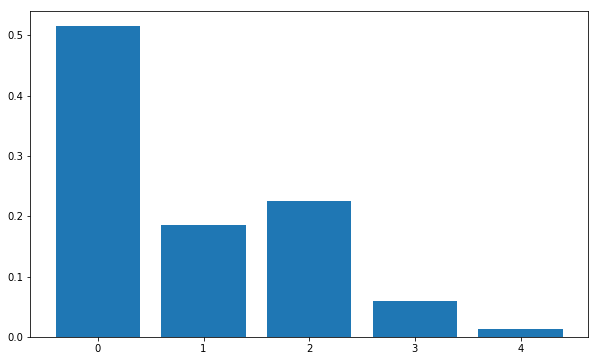

In [497]:
plt.bar(range(len(nmf_output)),nmf_output['Percent Dominance'])
plt.show()

In [555]:
for i in range(len(nmf.components_)):
    r = pandas.concat([pandas.DataFrame(nmf_transform),reviews[['review','sentiment']]],axis=1).sort_values(i,ascending=False).reset_index()
    rank = 10
    print('Topic {} {:1.4f}'.format(i,r.loc[rank,i]))
    print(r.loc[rank,'review'] + '\n')

Topic 0 0.0564
Apparently, this Jacylyn ** that they keep harassing me about is not paying her loan and must have given them a wrong number such as mine. They call me all the time even 8:00 am on Saturdays and 8:00 pm on Sunday. They won't stop. The people they have working there are incompetent and I do not know what to do to stop these harassing calls for someone else.

Topic 1 0.0974
My student loan interest is now 13%.  Which is crazy due to the current interest rate.  I got this loan on line and had no idea it was that high.  When trying to reduce it or have a co-signer I am told the only thing I can do is pay it off.  How can a student loan have that high of interest rate? Does anyone know how I can get this rate lowered.  Is there not a cap on interest rates for students.  I just finished four years at Columbia College Chicago. I do not want this to happen to another student.  13% is almost criminal!!!

Topic 2 0.0814
Over the course of the past year, Sallie Mae has: (1) applied

Finished 2 of 20
Finished 3 of 20
Finished 4 of 20
Finished 5 of 20
Finished 6 of 20
Finished 7 of 20
Finished 8 of 20
Finished 9 of 20
Finished 10 of 20
Finished 11 of 20
Finished 12 of 20
Finished 13 of 20
Finished 14 of 20
Finished 15 of 20
Finished 16 of 20
Finished 17 of 20
Finished 18 of 20
Finished 19 of 20
Finished 20 of 20


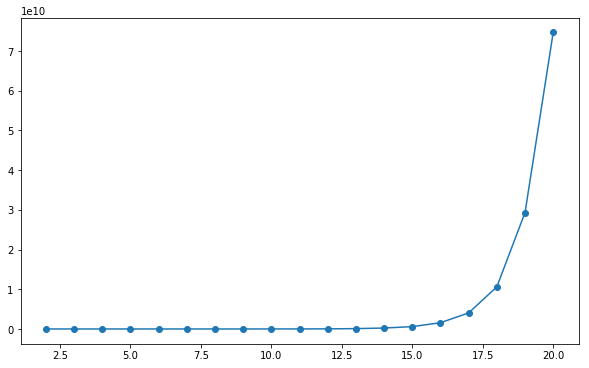

In [108]:
n_topic = range(2,21)
perplexities = []
for n in n_topic:
    lda = LatentDirichletAllocation(n_topics=n,max_iter=10,learning_method='batch',
                                    evaluate_every=0,n_jobs=7,random_state=20170206)
    lda.fit(tf)
    perplexities.append(lda.perplexity(tf))
    print('Finished %d of %d' % (n,max(n_topic)))
    
plt.plot(n_topic,perplexities,'-o')
plt.show()

In [534]:
# 15 topics via perplexity, but maybe not best
lda = LatentDirichletAllocation(n_topics=9,max_iter=100,learning_method='batch',
                                evaluate_every=0,n_jobs=4,random_state=20170206)
lda.fit(tf)
lda_transform = lda.transform(tf)

In [540]:
reg_lda = LogisticRegression(multi_class='multinomial',solver='newton-cg')
reg_lda.fit(lda_transform,reviews['sentiment'])
coef_lda = pandas.DataFrame(np.transpose(reg_lda.coef_),columns=[reviews['sentiment'][0]])
dominance = np.apply_along_axis(lambda x: [y for (y,z) in zip(range(len(x)),x) if z==max(x)][0],1,lda_transform)
dominance = pandas.Series(dominance)
dominance = dominance.value_counts()/len(dominance)
lda_output = pandas.concat([coef_lda,dominance,top_words(lda,tf_feature_names,20)],axis=1)
if reviews['sentiment'][0] == -1:
    response_label = 'Score for Negativity'
else:
    response_label = 'Score for Positivity'
lda_output.columns = [response_label,'Percent Dominance','Topic','Terms']
lda_output.to_excel('latent dirichlet allocation topics.xlsx',index=False)
lda_output

,Score for Negativity,Percent Dominance,Topic,Terms
0,-0.015204,0.074809,0,"letter,sent,never,year,collection,default,rece..."
1,0.322244,0.133588,1,"payment,told,month,called,said,due,could,make,..."
2,0.550359,0.127481,2,"payment,call,pay,time,said,one,month,money,nev..."
3,0.212763,0.030534,3,"forbearance,told,said,deferment,form,called,ba..."
4,-0.260187,0.180153,4,"payment,account,late,fee,check,bank,time,day,s..."
5,-0.067723,0.038168,5,"call,phone,number,day,son,time,calling,told,st..."
6,-0.253766,0.083969,6,"interest,payment,rate,year,amount,pay,balance,..."
7,0.116394,0.270992,7,"pay,job,month,time,year,make,money,work,go,one..."
8,-0.604878,0.060305,8,"credit,customer,service,account,report,informa..."


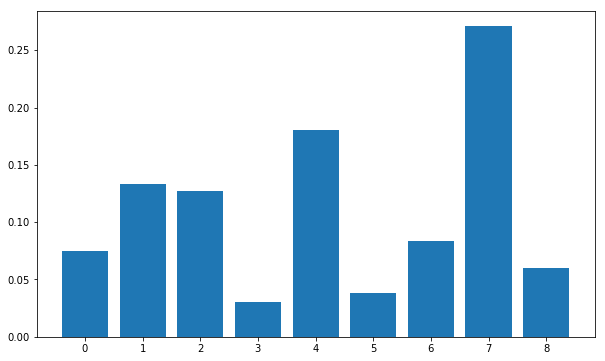

In [536]:
plt.bar(range(len(lda_output)),lda_output['Percent Dominance'],tick_label=range(len(lda_output)))
plt.show()

In [557]:
for i in range(len(lda.components_)):
    r = pandas.concat([pandas.DataFrame(lda_transform),reviews[['review','sentiment']]],axis=1).sort_values(i,ascending=False).reset_index()
    rank = 0
    print('Topic {} {:4.2f}%'.format(i,100*r.loc[rank,i]))
    print(r.loc[rank,'review'] + '\n')

Topic 0 98.49%
I attended College in 99 to 01 and I had to withdraw due to illness.I had my salliemae loans deferred and in 2003 I had them consolidated with Direct Loans. I recieved a letter from salliemae that my loans were consolidated to direct and they were paid in full. I did not hear anymore until Sept.of 07 when my husband was arrested for failure to appear. Even though we did move in 03 I still had all my mail forwarded and salliemae did not ever send me anything. So we lost 2 days work and had to shell out $500. I have hired an attorney for chapter 7. Now I get a summons for court and they are planning to garnish my and my husbands wages. They now say they hold one loan not eligible for consolidation but will not say why.2 days lost wages in Sept 07, $500 and mental stress due to impending garnishment, this would put a financial strain on us. $1300 to lawyer for chapter 7. Repeated harassment from courts and Attorney David Blaskovich.

Topic 1 99.29%
I spoke with my previous 

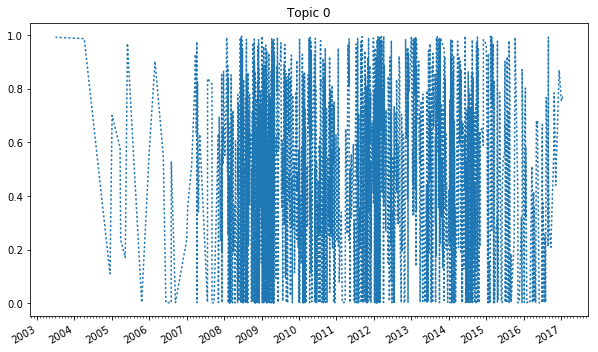

In [50]:
lda_date_frame = pandas.concat([pandas.DataFrame(lda_transform),reviews[['datetime','sentiment']]],axis=1)
lda_date_frame.rename(columns=dict(zip([i for i in range(len(lda.components_))],['T'+str(i) for i in range(len(lda.components_))])),inplace=True)
lda_date_frame.to_csv('lda_data.csv',index=False)

nmf_date_frame = pandas.concat([pandas.DataFrame(nmf_transform),reviews[['datetime','sentiment']]],axis=1)
nmf_date_frame.rename(columns=dict(zip([i for i in range(len(nmf.components_))],['T'+str(i) for i in range(len(nmf.components_))])),inplace=True)
nmf_date_frame.to_csv('nmf_data.csv',index=False)

date_vals = lda_date_frame['datetime'].apply(lambda x: mpd.date2num(x.to_pydatetime()))
years = mpd.YearLocator()
months = mpd.MonthLocator()

nmf_date_frame = pandas.concat([pandas.DataFrame(lda_transform),reviews[['datetime','sentiment']]],axis=1)
lda_date_frame.rename(columns=dict(zip([i for i in range(len(lda.components_))],['T'+str(i) for i in range(len(lda.components_))])),inplace=True)
lda_date_frame.to_csv('lda_data.csv',index=False)

fig, ax = plt.subplots()
ax.plot_date(date_vals, lda_date_frame['T0'], ':')
# format the ticks
ax.xaxis.set_major_locator(years)
#ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)
ax.autoscale_view()
fig.autofmt_xdate()
plt.title('Topic 0')
plt.show()

In [558]:
lsa = TruncatedSVD(n_components=100,algorithm='arpack',random_state=20170207)
lsa_matrix = lsa.fit_transform(tfidf)

In [569]:
ap = AffinityPropagation(damping=0.55,preference=-0.25,copy=True,verbose=True,max_iter=100)
ap.fit(lsa_matrix)

Converged after 75 iterations.


AffinityPropagation(affinity='euclidean', convergence_iter=15, copy=True,
          damping=0.55, max_iter=100, preference=-0.25, verbose=True)

In [570]:
cluster_centers_indices = ap.cluster_centers_indices_
labels = ap.labels_
n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(lsa_matrix, labels, metric='sqeuclidean'))

Estimated number of clusters: 2
Silhouette Coefficient: 0.137


In [571]:
cluster_terms = pandas.DataFrame(tfidf.todense())
cluster_terms.columns = feature_names
cluster_terms = pandas.concat([cluster_terms,pandas.Series(labels,name='cluster')],axis=1)
cluster_terms = cluster_terms.groupby('cluster').median().transpose()
cluster_terms.columns = ['c'+str(x) for x in cluster_terms.columns]

clus_matrix = pandas.get_dummies(labels)

In [572]:
clus_matrix.apply(sum)

0    883
1    427
dtype: int64

In [573]:
ranked_words = []
for i in cluster_terms.columns:
    display(cluster_terms.loc[cluster_terms[i] > 0,i].to_frame().sort_values(i,ascending=False))
    ranked_words.append(cluster_terms.loc[cluster_terms[i] > 0,i].to_frame().sort_values(i,ascending=False).index.values)

,c0
payment,0.006103
time,0.004248
pay,0.004014
month,0.002817


,c1
payment,0.010427
time,0.005003
call,0.003166


In [574]:
reg_clus = LogisticRegression(multi_class='multinomial',solver='newton-cg',fit_intercept=True)
reg_clus.fit(clus_matrix,reviews['sentiment'])
coef_clus = pandas.DataFrame(np.transpose(reg_clus.coef_),columns=[reviews['sentiment'][0]])
clus_output = pandas.concat([coef_clus,pandas.Series(range(len(coef_clus))),pandas.Series(ranked_words)],axis=1)
clus_output.columns = ['Score for Negativity','Cluster','Terms']
#clus_output.to_excel('cluster topics.xlsx',index=False)
clus_output

,Score for Negativity,Cluster,Terms
0,0.08177,0,"[payment, time, pay, month]"
1,-0.08177,1,"[payment, time, call]"
